In [1]:
import os
import glob
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
dataPath = "../1_Data_Preprocessing/32Sample/3Class/GADF_3Class_32Sample.npz"
data = np.load(dataPath)

X_data = data['X_data']
y_data = data['y_data']
i_data = data['i_data']

data.close()

print("X_data: ", X_data.shape)
print("y_data: ", y_data.shape)
print("i_data: ", i_data.shape)

X_data:  (1080, 32, 32, 3)
y_data:  (1080,)
i_data:  (1080,)


In [3]:
# Data split

# Set random seed for reproductivity
seed = 42

# Train - Test split
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_data)

# Train - Validation split
X_train, X_val, y_train, y_val, i_train, i_val = train_test_split(X_train, y_train, i_train, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)
print(i_train.shape, i_test.shape, i_val.shape)

print(np.unique(y_train, return_counts= True))
print(np.unique(y_test, return_counts= True))
print(np.unique(y_val, return_counts= True))

(691, 32, 32, 3) (216, 32, 32, 3) (173, 32, 32, 3)
(691,) (216,) (173,)
(691,) (216,) (173,)
(array([0, 1, 2]), array([231, 230, 230], dtype=int64))
(array([0, 1, 2]), array([72, 72, 72], dtype=int64))
(array([0, 1, 2]), array([57, 58, 58], dtype=int64))


In [4]:
# One - hot encoding
trainTargets = to_categorical(y_train)
testTargets = to_categorical(y_test)
valTargets = to_categorical(y_val)

print("Train targets: ", trainTargets.shape)
print("Test targets: ", testTargets.shape)
print("Validation targets: ", valTargets.shape)

Train targets:  (691, 3)
Test targets:  (216, 3)
Validation targets:  (173, 3)


In [5]:
weightPath = "./weights/"

In [6]:
# MobileNetV2 Transfer-learning
# Import convolution layer
# weight = None

with tf.device("/device:GPU:0"):
    inputTensor = Input(shape= (32, 32, 3))

    model = MobileNetV2(input_tensor= inputTensor,              # Input data shape
                        include_top= False,                     # Only convolution layer. If True: Use Classification layer
                        weights= None,                          # If weights= "imagenet" --> Use imagenet weights
                        pooling= 'max')

    x = model.output
    x = Dense(3, activation= 'softmax', kernel_initializer= 'he_normal')(x)

    model = Model(model.input, x)

    # Instantiate optimizer
    optim = optimizers.SGD(learning_rate= 0.01,
                           decay= 1e-3,
                           momentum= 0.9,
                           nesterov= True)

    # Compile model
    model.compile(optimizer= optim,
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

    print("Training======================================")
    startTime = time.time()                                     # Training start time

    history = model.fit(X_train, trainTargets,
                        batch_size= 16,
                        epochs= 150,
                        verbose= 1,
                        validation_data= (X_val, valTargets)
                        )
    
    endTime = time.time()                                       # Training end time
    print(f"Training time: {np.round(endTime - startTime, 3)} sec")

    # save weight file
    model.save(os.path.join(weightPath, "GADF_MobileNetV2_3Class_32Sample.h5"))

    # Evaluate for total train dataset
    print("Score for train dataset")
    score = model.evaluate(X_train, trainTargets, verbose= 1)
    print(f"Score: \n{model.metrics_names[0]} : {score[0]}\n{model.metrics_names[0]} : {score[1] * 100} %")

Training======================================
Epoch 1/150
44/44 [==============================] - 8s 61ms/step - loss: 0.8072 - accuracy: 0.7525 - val_loss: 1.0996 - val_accuracy: 0.3353
Epoch 2/150
44/44 [==============================] - 1s 24ms/step - loss: 0.3655 - accuracy: 0.9045 - val_loss: 1.1031 - val_accuracy: 0.3295
Epoch 3/150
44/44 [==============================] - 1s 24ms/step - loss: 0.2175 - accuracy: 0.9276 - val_loss: 1.1000 - val_accuracy: 0.3295
Epoch 4/150
44/44 [==============================] - 1s 23ms/step - loss: 0.3017 - accuracy: 0.9161 - val_loss: 1.1006 - val_accuracy: 0.3353
Epoch 5/150
44/44 [==============================] - 1s 23ms/step - loss: 0.1998 - accuracy: 0.9450 - val_loss: 1.1050 - val_accuracy: 0.3295
Epoch 6/150
44/44 [==============================] - 1s 23ms/step - loss: 0.1555 - accuracy: 0.9566 - val_loss: 1.1090 - val_accuracy: 0.3353
Epoch 7/150
44/44 [==============================] - 1s 23ms/step - loss: 0.0353 - accuracy: 0.9884 -

In [7]:
def plotHistory(history, train, validation):
    """
        plot training history
        Parameters
        ------------------------------
        history = history
        train = 'accuracy' or 'loss'
        validation = 'val_accuracy' or 'val_loss'
    """
    plt.figure(figsize= (8, 6))
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.legend(['train', 'validation'], loc= 'center right')
    plt.xlabel("Epochs")
    if train == 'accuracy':
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy for train dataset")
    elif train == "loss":
        plt.ylabel("Loss")
        plt.title("Loss for train dataset")
    plt.show()

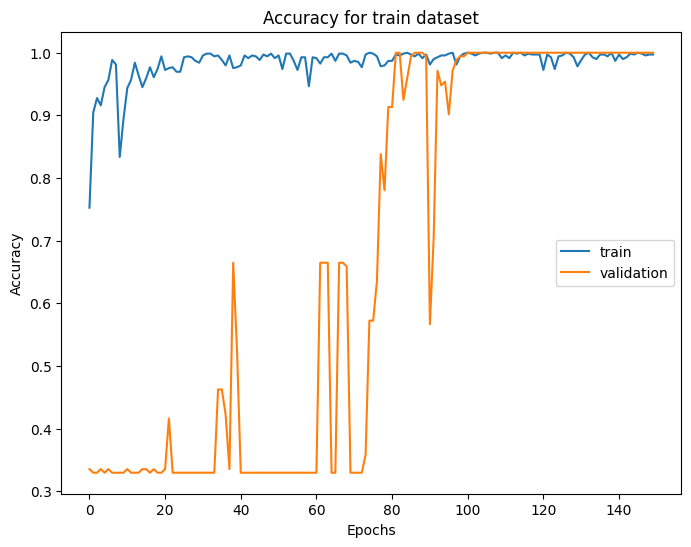

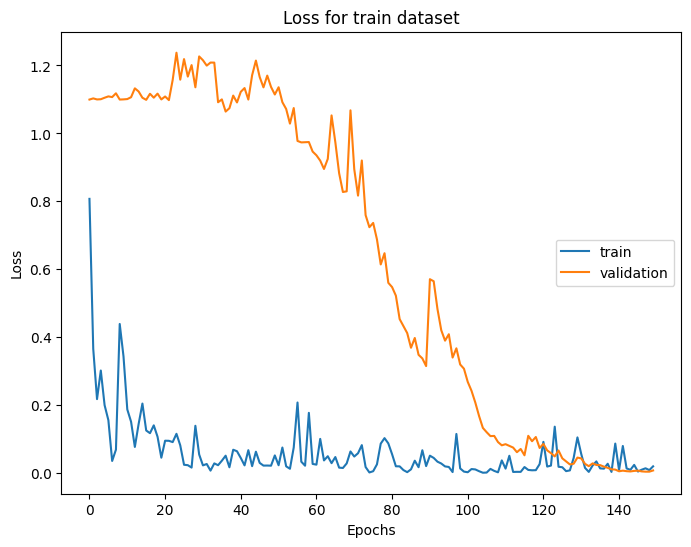

In [8]:
plotHistory(history= history, train= 'accuracy', validation= 'val_accuracy')
plotHistory(history= history, train= 'loss', validation= 'val_loss')

In [9]:
# Evaluate test dataset
testScore = model.evaluate(X_test, testTargets, verbose= 1)
print(f"{model.metrics_names[0]} : {testScore[0]}\n{model.metrics_names[1]} : {testScore[1] * 100} %")

7/7 [==============================] - 0s 54ms/step - loss: 0.0074 - accuracy: 1.0000
loss : 0.007436208892613649
accuracy : 100.0 %


7/7 [==============================] - 1s 9ms/step
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        72
           2       1.00      1.00      1.00        72

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



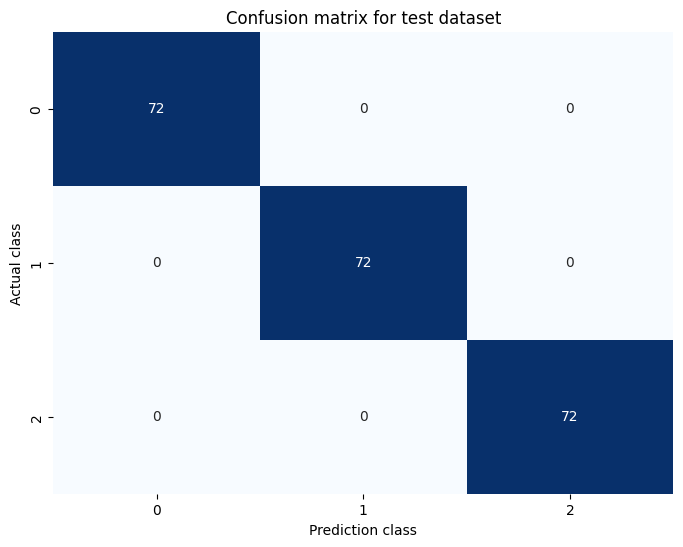

In [10]:
# Prediction for test dataset

prediction = model.predict(X_test)
predictionClass = np.argmax(prediction, axis= 1)        # One-hot encoding --> Original label

# Actual Class (One-hot encoding testTarget --> y_test)
if testTargets.ndim > 1:
    actualClass = np.argmax(testTargets, axis= 1)
else:
    actualClass = testTargets

# Classification report
print(f"Classification report: \n{classification_report(actualClass, predictionClass)}")

# Confusion matrix
plt.figure(figsize= (8, 6))
sns.heatmap(confusion_matrix(actualClass, predictionClass), 
            annot= True, 
            fmt= "d", 
            cmap= "Blues",
            cbar= False)
plt.title("Confusion matrix for test dataset")
plt.xlabel("Prediction class")
plt.ylabel("Actual class")
plt.show()

In [11]:
# Prediction for 1 image

randomImgIdx = random.randrange(0, X_test.shape[0])

predictStartTime = time.time()

predictionImg = X_test[randomImgIdx]
predictionImg = np.expand_dims(predictionImg, axis= 0)

testPrediction = model.predict(predictionImg)

predictEndTime = time.time()

print("Random image index: ", randomImgIdx)
print("Random actual label: ", i_test[randomImgIdx])
print("Random actual class: ", actualClass[randomImgIdx])
print("Random prediction class: ", predictionClass[randomImgIdx])

1/1 [==============================] - 0s 253ms/step
Random image index:  137
Random actual label:  L_94
Random actual class:  1
Random prediction class:  1
